# Setup

In [1]:
# Python 3 compatability
from __future__ import division, print_function

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
import scipy
from scipy import stats

# plotting
import matplotlib
from matplotlib import pyplot as plt

# fits data
from astropy.io import fits

# inline plotting
%matplotlib inline

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

# Star with Position Fixed and Free

Load and process data.

In [65]:
# extract data
hdul = fits.open('data/noise_exp.fits')
header = hdul[0].header
f = header['TRUEFLUX']
ferr = np.sqrt(4 * np.pi * header['PSFWIDTH']**2 * header['NOISE']**2)
xerr = np.sqrt(8 * np.pi * header['PSFWIDTH']**4 *
               header['NOISE']**2 / header['TRUEFLUX']**2)
data = hdul[1].data
nruns = len(data)
flux, flux_fixed, err = data['Flux'], data['F_FixPos'], data['FluxErr']
x, y = data['X'], data['Y']

In [72]:
# define relevant quantities
dx = x / xerr  # normalized deviation (position)
snr = f / ferr  # true SNR
df_var = (flux - f) / ferr  # normalized deviation (ML flux)
df_fix = (flux_fixed - f) / ferr  # noramlized deviation (flux at true position)

Plot flux offset as a function of position offset.

In [234]:
# construct smoothed (binned) KDE
from scipy.ndimage.filters import gaussian_filter
sig, smooth, grid = 5, 0.6, 5e-3
n, bx, by = np.histogram2d(dx, df_fix, np.arange(-sig, sig + grid, grid))
ns = gaussian_filter(n, smooth / grid)

In [259]:
# normalize to 1 in each row
ns /= np.nanmax(ns, axis=0)

# compute quantiles
quantiles = [0.025, 0.16, 0.5, 0.84, 0.975]
qs = []
for q in quantiles:
    qs.append(by[np.argmin((ns.cumsum(axis=0) - q * ns.sum(axis=0))**2, axis=0)])

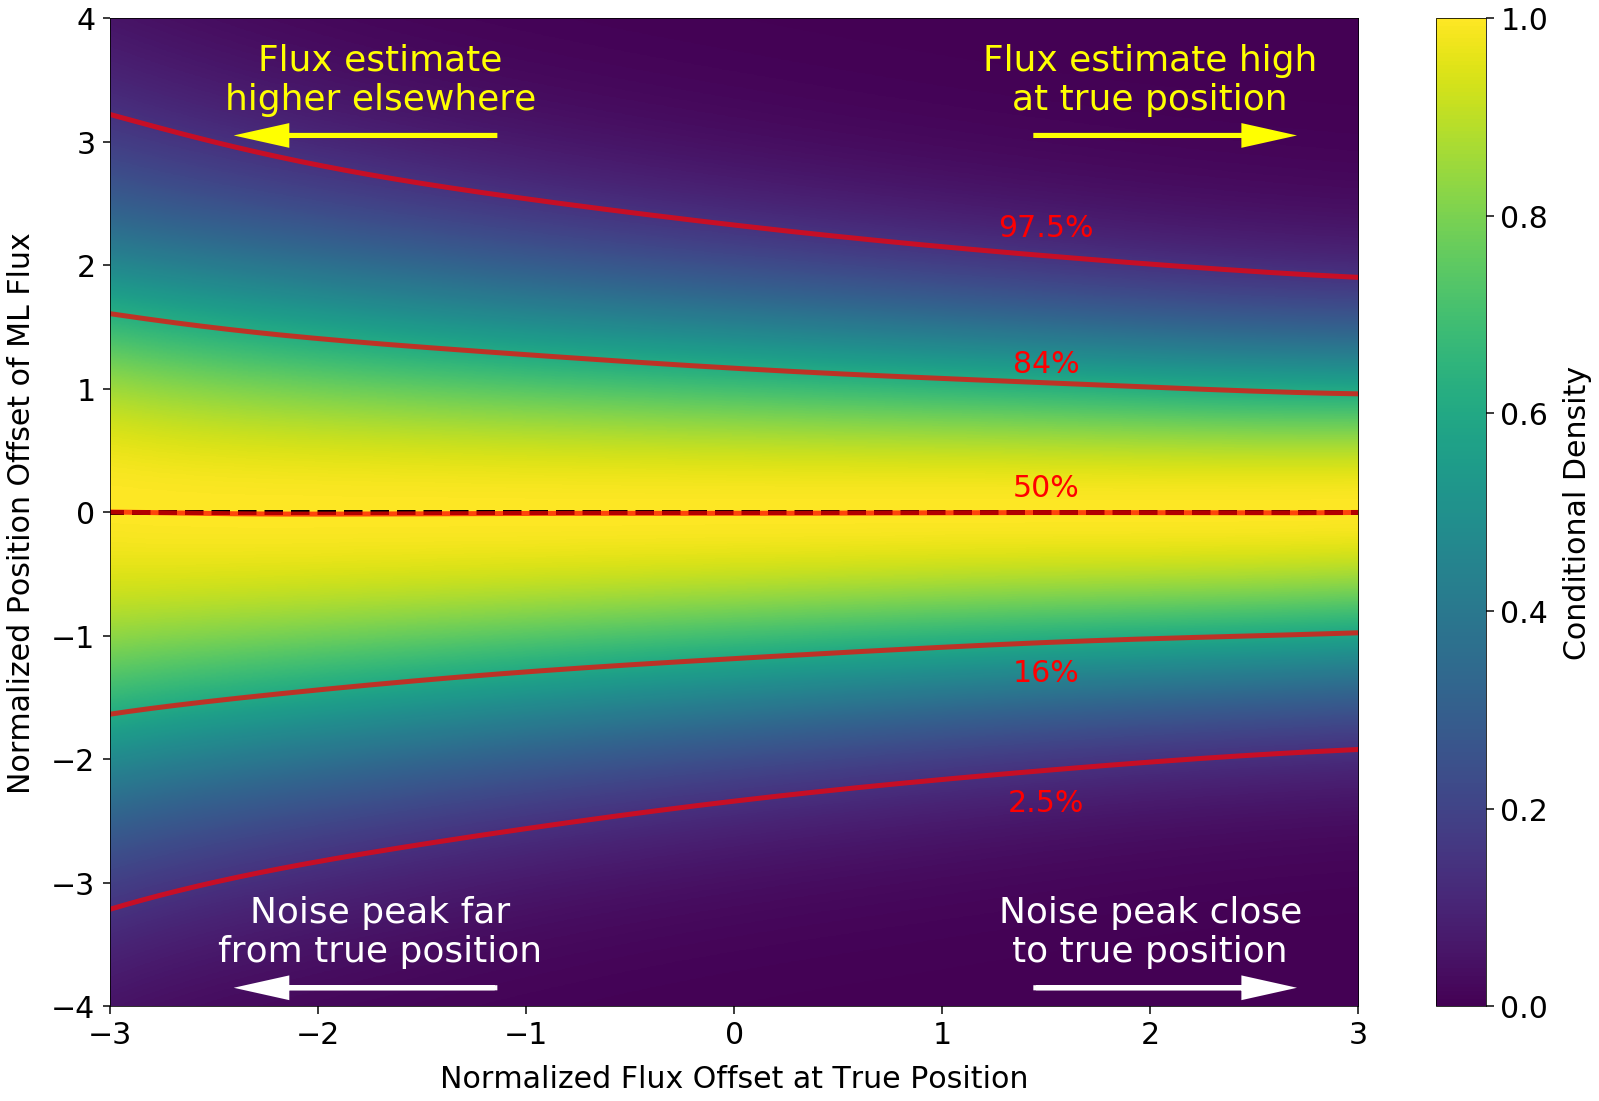

In [377]:
# plot conditional density
plt.figure(figsize=(24, 16))
plt.imshow(ns, extent=[-sig, sig, -sig, sig], aspect='auto',
           origin='lower', cmap='viridis')

# plot quantiles
plt.plot([-sig, sig], [0., 0.], lw=5, color='black', ls='--')
for i, q in enumerate(qs):
    q_poly = np.polyfit((bx[1:] + bx[:-1]) / 2, q, deg=10)  # polynomial smoothing
    q_interp = np.poly1d(q_poly)((bx[1:] + bx[:-1]) / 2)  # interpolate onto grid
    plt.plot((bx[1:] + bx[:-1]) / 2, q_interp, color='red', 
             lw=5, alpha=0.7)
    
# prettify
plt.text(1.5, -2.35, '2.5%', color='red',
         horizontalalignment='center', verticalalignment='center')
plt.text(1.5, -1.3, '16%', color='red',
         horizontalalignment='center', verticalalignment='center')
plt.text(1.5, 0.2, '50%', color='red',
         horizontalalignment='center', verticalalignment='center')
plt.text(1.5, 1.2, '84%', color='red',
         horizontalalignment='center', verticalalignment='center')
plt.text(1.5, 2.3, '97.5%', color='red',
         horizontalalignment='center', verticalalignment='center')
plt.text(-1.7, -3.4, 'Noise peak far\nfrom true position',
         horizontalalignment='center', verticalalignment='center',
         color='white', fontsize=36)
plt.arrow(-1.15, -3.85, -1., 0., head_width=0.15, head_length=0.2,
          facecolor='white', edgecolor='white', linewidth=5)
plt.text(2.0, -3.4, 'Noise peak close\nto true position',
         horizontalalignment='center', verticalalignment='center',
         color='white', fontsize=36)
plt.arrow(1.45, -3.85, 1., 0., head_width=0.15, head_length=0.2,
          facecolor='white', edgecolor='white', linewidth=5)
plt.text(-1.7, 3.5, 'Flux estimate\nhigher elsewhere',
         horizontalalignment='center', verticalalignment='center',
         color='yellow', fontsize=36)
plt.arrow(-1.15, 3.05, -1., 0., head_width=0.15, head_length=0.2,
          facecolor='yellow', edgecolor='yellow', linewidth=5)
plt.text(2.0, 3.5, 'Flux estimate high\nat true position',
         horizontalalignment='center', verticalalignment='center',
         color='yellow', fontsize=36)
plt.arrow(1.45, 3.05, 1., 0., head_width=0.15, head_length=0.2,
          facecolor='yellow', edgecolor='yellow', linewidth=5)
plt.xlabel(r'Normalized Flux Offset at True Position')
plt.ylabel(r'Normalized Position Offset of ML Flux')
plt.xlim([-(sig-2), (sig-2)])
plt.ylim([-(sig-1), (sig-1)])
plt.colorbar(label='Conditional Density')
plt.tight_layout()

# save figure
plt.savefig('plots/star_varpos.png', bbox_inches='tight')